Bunch of code to inspect each ROI's signal compared to a few basic behavioural variables

In [61]:
from vgatPAG.database.db_tables import *

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
from random import choices

from brainrender.colors import colorMap

from fcutils.plotting.plot_elements import plot_shaded_withline
from fcutils.plotting.plot_distributions import plot_kde
from fcutils.plotting.colors import *
from fcutils.plotting.utils import save_figure, clean_axes

settings: screenshots are set to have transparent backgroundset the parameter "SCREENSHOT_TRANSPARENT_BACKGROUND" to false if you would prefer a not transparent background


In [ ]:
def get_mouse_session_data(mouse, session):
    if session not in sessions[mouse]: raise ValueError('Invalide session/mouse combo')

    # Get individual recording's within the session, and the calcium data for each
    recs = Recording().get_sessions_recordings(mouse, session)
    roi_ids, roi_sigs, nrois = Roi().get_sessions_rois(mouse, session)
    roi_ids = list(roi_ids.values())[0]

    # print(f'\nNumber of rois per recording: | should be the same for each recording\n  {nrois}')

    # Concatenate calcium signals
    _signals = [[] for i in np.arange(nrois[recs[0]])]
    is_rec = []

    for rec in recs:
        is_rec.append((TiffTimes & f"rec_name='{rec}'").fetch1("is_ca_recording"))

        sigs = roi_sigs[rec]
        for r, roi in enumerate(sigs):
            _signals[r].append(roi)

    is_rec = np.hstack(is_rec)
    signals = [np.hstack(s).T for s in _signals]
    _nrois = len(signals)

    # Get tracking data 
    body_tracking, ang_vel, speed, shelter_distance = [], [], [], []
    for rec in recs:
        bt, av, s, sd = Trackings().get_recording_tracking_clean(mouse_name=mouse, sess_name=session, rec_name=rec)
        body_tracking.append(bt)
        ang_vel.append(av)
        speed.append(s)
        shelter_distance.append(sd)

    body_tracking = np.hstack(body_tracking)
    ang_vel = np.hstack(ang_vel).T
    speed = np.hstack(speed).T
    shelter_distance = np.hstack(shelter_distance).T

    tracking = pd.DataFrame(dict(x = body_tracking[0, :], y=body_tracking[1, :], s=body_tracking[1, :])).interpolate()

    # Make sure stuff has right length
    clean_signal = []
    for sig in signals:
        if len(sig) < len(tracking):
            s = np.zeros((len(tracking)))
            s[:len(sig)] = sig
            clean_signal.append(s)
        elif len(sig) == len(tracking):
            clean_signal.append(sig)
        else:
            raise ValueError
    
    if len(is_rec) < len(tracking):
        a = np.zeros((len(tracking)))
        a[:len(is_rec)] = is_rec
        is_rec = a

    return tracking, ang_vel, speed, shelter_distance, clean_signal, _nrois, is_rec

# Fetching data

Fetching data involves two steps:
1) Get the data for a specific session (experiment) of a specific mouse from the datajoint database
2) Concatenate akk the different data streams from each recording wihtin the session


In [4]:

# Get all mice
mice = Mouse.fetch("mouse")

# Get all sessions
sessions = {m:(Session & f"mouse='{m}'").fetch("sess_name") for m in mice}

# Get the recordings for each session
recordings = {m:{s:(Recording & f"sess_name='{s}'" & f"mouse='{m}'").fetch(as_dict=True) for s in sessions[m]} for m in mice}


######  Specify data to analyse #####
mouse = 'BF164p1'
sess = '19JUN05'

##### Get data and concatenate ######


In [7]:
for _mouse in mice:
    print(f'\n{mouse}:')
    for _session in sessions[_mouse]:
        print(f"      |---{_session}")

        recs = Recording().get_sessions_recordings(_mouse, _session)
        print("      |       |--", end='')
        print(*recs, sep=" || ")        



BF164p1:
      |---19JUN03
      |       |--19JUN03_BF161p1_v1 || 19JUN03_BF161p1_v2
      |---19JUN04
      |       |--19JUN04_BF161p1_v1 || 19JUN04_BF161p1_v2

BF164p1:
      |---19JUN05
      |       |--19JUN05_BF164p1_GCaMP_v1
      |---19JUN18
      |       |--19JUN19_BF164p1_GCaMP_t1 || 19JUN19_BF164p1_GCaMP_t2 || 19JUN19_BF164p1_GCaMP_t3_chase

BF164p1:
      |---19JUL15
      |       |--19JUL15_BF164p2_GCaMP_t1 || 19JUL15_BF164p2_GCaMP_t2
      |---19JUN24
      |       |--19JUN24_BF164p2_GCaMP_t2
      |---19JUN26
      |       |--19JUN26_BF164p2_GCaMP_t1

BF164p1:
      |---19JUN05
      |       |--19JUN05_BF166p3_GCaMP_t2 || 19JUN05_BF166p3_GCaMP_t3 || 19JUN05_BF166p3_GCaMP_t4
      |---19JUN19
      |       |--19JUN19_BF166p3_GCaMP_t2 || 19JUN19_BF166p3_GCaMP_t3


In [6]:
session = sess    
vstims = (VisualStimuli & f"sess_name='{session}'" & f"mouse='{mouse}'").fetch("frame")
astims = (AudioStimuli & f"sess_name='{session}'" & f"mouse='{mouse}'").fetch("frame")

# Plotting
## Position

Look at the activity of different rois as a function of location in the arena

In [ ]:
# Utility funcs
def get_binned_pc(dflist):
    # Given a list of dataframes with activity binned along one axis,
    # computes PCA and returns the results

    # Get bins
    x_bins = dflist[0].index.values
    int_values = np.array([(i.left + i.right)/2 for i in x_bins])

    # Get signal and remove nans
    binned_signals = np.vstack([df.interpolate().sig.values for df in dflist]).T
    binned_signals[np.isnan(binned_signals)]  = 0

    # Do PCA
    pca = PCA(n_components=1)
    PC = pca.fit_transform(binned_signals)

    # Nan first bins
    PC[(int_values < 250)|(int_values>950)] = np.nan
    
    return int_values, PC


In [ ]:
plt.ioff()

# Params
xbins, ybins = 25, 15
exploration_only = False

# Figure making
for mouse in tqdm(mice):

    all_pcas = []
    for sess in sessions[mouse]:
        x_binned_activity = []
        if exploration_only:
            first_stim = Recording().get_session_first_stim(mouse, sess) 
        else:
            first_stim = True

        if not first_stim: 
            continue

        tracking, ang_vel, speed, shelter_distance, signals, _nrois, is_rec = get_mouse_session_data(mouse, sess)

        if len(tracking) != len(signals[0]):
            raise ValueError

        f, axarr = plt.subplots(ncols = 6, nrows=4, figsize=(25, 18))
        axarr = axarr.flatten()
        f.suptitle(f"{mouse} - {sess}")

        for n in np.arange(_nrois):
            # Plot activity projected ont X and Y axis
            trace = pd.DataFrame(dict(
                x = np.int64(tracking['x'].values),
                y = np.int64(tracking['y'].values),
                sig = signals[n],
                isrec = is_rec,
            ))

            if exploration_only: # Keep only up to first stim
                trace = trace[:first_stim]

            if not len(trace): continue

            # ! keep only data for when we are recording
            trace = trace.loc[trace.isrec > 0]
            if not len(trace): continue

            # Plot tracking and binned activity
            axarr[n].set(title=f'ROI {n}')
            axarr[n].hexbin(trace['x'], trace['y'], C=trace.sig, gridsize=xbins, reduce_C_function=np.mean)


            # Bind data along x and y directions
            df = trace.groupby(pd.cut(trace['x'], bins=xbins)).mean()
            int_values = np.array([(i.left + i.right)/2 for i in df.index.values])
            df[int_values < 250] = np.nan
            df[int_values > 950] = np.nan
            plot_shaded_withline(axarr[n], int_values, ((df['sig']/df['sig'].max())*100), z=0, lw=1, color='salmon') # scale the plot to fit nicely
            x_binned_activity.append(df.interpolate())


            df = trace.groupby(pd.cut(trace['y'], bins=ybins)).mean()
            int_values = [(i.left + i.right)/2 for i in df.index.values]
            axarr[n].plot( ((df['sig']/df['sig'].max())*100)+1100, int_values,  lw=4, color='darkseagreen') # scale the plot to fit nicely


            # break
        
        # Plot bin occupancy from tracking
        axarr[-1].hexbin(tracking['x'], tracking['y'], gridsize=xbins, bins='log', mincnt=1, cmap='inferno')
        _ = axarr[-1].set(title='Bin occupancy log scale')

        # Plot PCA of activity binned on X axis
        if len(x_binned_activity):
            x_bins, PC = get_binned_pc(x_binned_activity)
            axarr[-2].plot(x_bins, PC, lw=2, color=darkseagreen) 
            axarr[-2].set(title='PCA on pop activity binned by X position', xlabel='X position', ylabel='PC1', xlim=[100, 1200])
            all_pcas.append(PC.ravel())

        # Clean axes and save figure
        clean_axes(f)
        f.tight_layout()
        save_figure(f, f'C:\\Users\\Federico\\Documents\\GitHub\\vgatPAG\\plots\\{mouse}_{sess}_ontracking_{"exp" if exploration_only else "all"}', verbose=False)
        plt.close(f)

        # break
    # break

plt.ion()

print('\ndone')

Plot activity of each ROI binned by X position

4it [00:18,  4.57s/it]


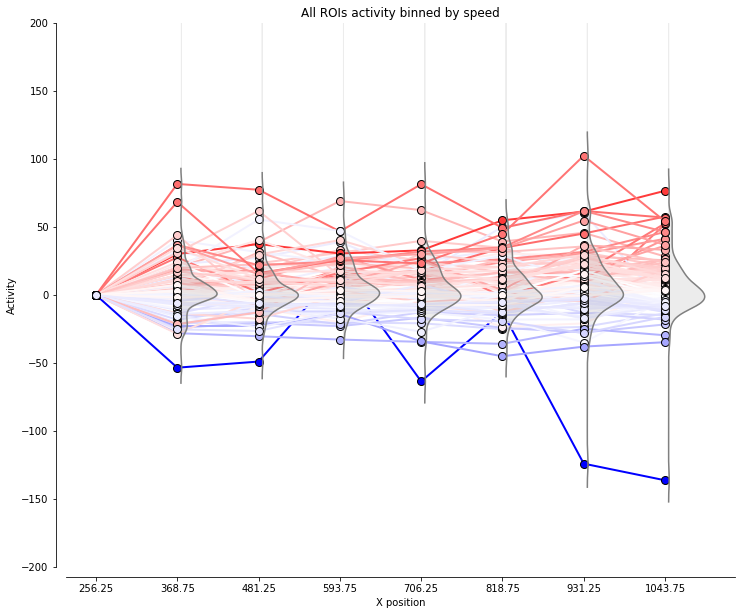

In [178]:
# f, axarr = plt.subplots(ncols =  3, nrows=4, figsize=(25, 18))
f, ax = plt.subplots(figsize=(12, 10))
normalize = True
th = 5

px_to_cm = 13.9

endpoints = [[] for i in np.arange(8)]
for n, mouse in tqdm(enumerate(mice)):
    for s, sess in enumerate(sessions[mouse]):

        # axarr[n, s].set(title=f"{mouse} - {sess}")


        tracking, ang_vel, speed, shelter_distance, signals, _nrois, is_rec = get_mouse_session_data(mouse, sess)
        # remove speed outliers
        speed[speed>np.nanpercentile(speed, 99)] = np.nanpercentile(speed, 99)



        for nroi in np.arange(_nrois):
            trace = pd.DataFrame(dict(
                    x = np.int64(tracking['x'].values),
                    y = np.int64(tracking['y'].values),
                    s =speed,
                    sig = signals[nroi],
                    isrec = is_rec,
                )).interpolate()

            trace = trace.loc[trace.isrec > 0]

            df = trace.groupby(pd.cut(trace['x'], bins= np.linspace(200, 1100, 9))).mean()
            int_values = np.array([(i.left + i.right)/2 for i in df.index.values])


            y = df.sig

            if normalize:
                y -= y[0]

            if not np.any(np.isnan(y[-1])):
                color = colorMap(y[-1], 'bwr', vmin=-100, vmax=100)
            else:
                color = colorMap(y[-2], 'bwr', vmin=-100, vmax=100)
            ax.plot(int_values, y, 'o-', lw=2, ms=8, mec='k', label=f'roi {nroi}', color=color)
            # axarr[n, s]

            for k, yy in enumerate(y):
                if  not np.any(np.isnan(yy)):
                    endpoints[k].append(yy)


        # axarr[n, s].legend()
        # break
    # break
for k, endp in enumerate(endpoints):
    if k == 0: continue
    plot_kde(data=endp, vertical=True, normto=50, z=int_values[k]+5, ax=ax,  color='gray', zorder=99)


ax.set(title='All ROIs activity binned by speed', xticks=int_values, xticklabels=int_values, xlabel='X position',
                ylabel='Activity', ylim=[-200, 200])

clean_axes(f)
save_figure(f, f'C:\\Users\\Federico\\Documents\\GitHub\\vgatPAG\\plots\\allrois_space_modulation', verbose=False)
plt.show()


In [176]:
int_values

array([ 256.25,  368.75,  481.25,  593.75,  706.25,  818.75,  931.25,
       1043.75])

# Plotting

## Speed
Plotting CA activity binned by speed

4it [00:19,  4.78s/it]


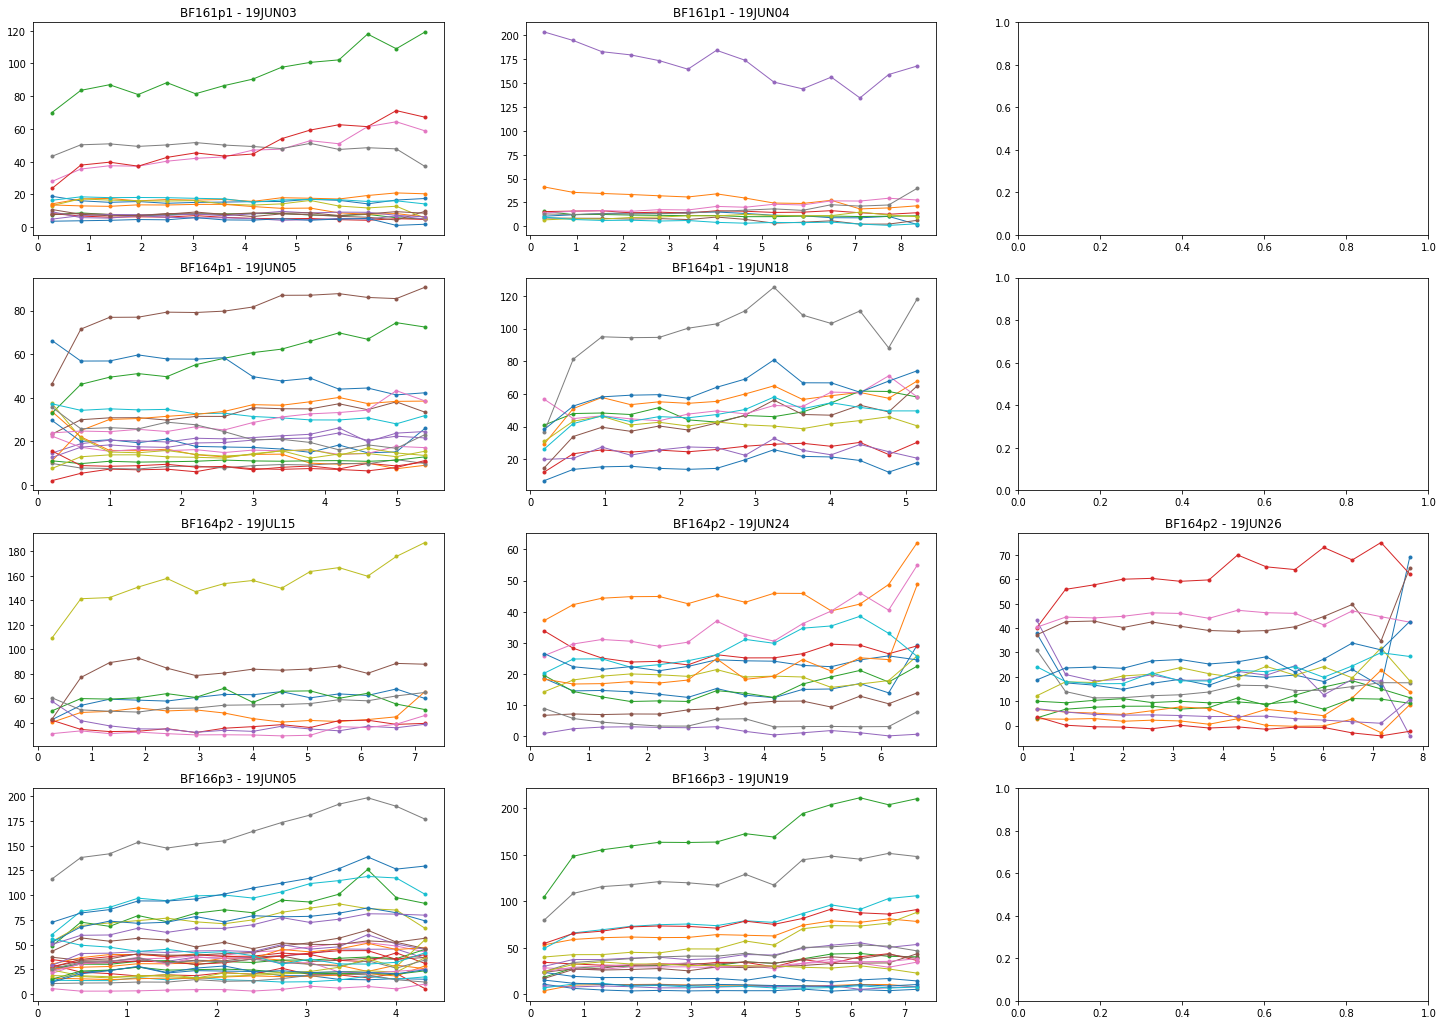

In [55]:
# Plotting linear regression betwen speed and calcium activity
f, axarr = plt.subplots(ncols =  3, nrows=4, figsize=(25, 18))



for n, mouse in tqdm(enumerate(mice)):
    for s, sess in enumerate(sessions[mouse]):

        axarr[n, s].set(title=f"{mouse} - {sess}")


        tracking, ang_vel, speed, shelter_distance, signals, _nrois, is_rec = get_mouse_session_data(mouse, sess)
        # remove speed outliers
        speed[speed>np.nanpercentile(speed, 99)] = np.nanpercentile(speed, 99)



        for nroi in np.arange(_nrois):
            trace = pd.DataFrame(dict(
                    x = np.int64(tracking['x'].values),
                    y = np.int64(tracking['y'].values),
                    s =speed,
                    sig = signals[nroi],
                    isrec = is_rec,
                )).interpolate()

            trace = trace.loc[trace.isrec > 0]


            df = trace.groupby(pd.cut(trace['s'], bins=14)).mean()
            int_values = [(i.left + i.right)/2 for i in df.index.values]
            
            axarr[n, s].plot(int_values, df.sig, 'o-', lw=1, ms=3, label=f'roi {nroi}')

        # axarr[n, s].legend()
        # break
    # break
plt.show()


Plot speed and tracking overlay

4it [00:15,  3.92s/it]


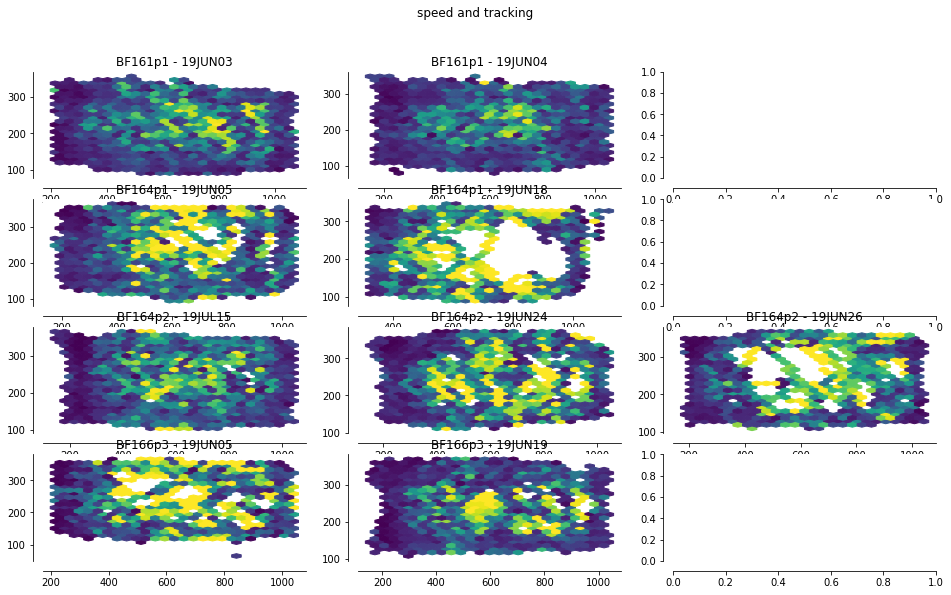

In [154]:

# Params
xbins, ybins = 25, 15
exploration_only = False

f, axarr = plt.subplots(ncols = 3, nrows=4, figsize=(16, 9))
f.suptitle(f"speed and tracking")

# Figure making
for m, mouse in tqdm(enumerate(mice)):
        for s, sess in enumerate(sessions[mouse]):
            tracking, ang_vel, speed, shelter_distance, signals, _nrois, is_rec = get_mouse_session_data(mouse, sess)
            # remove speed outliers
            speed[speed>np.nanpercentile(speed, 99)] = np.nanpercentile(speed, 99)
            trace = pd.DataFrame(dict(
                x = np.int64(tracking['x'].values),
                y = np.int64(tracking['y'].values),
                speed = speed,
            ))

        
            # Plot tracking and binned activity
            axarr[m, s].hexbin(trace['x'], trace['y'], C=trace.speed, gridsize=xbins, reduce_C_function=np.mean)
            axarr[m, s].set(title=f'{mouse} - {sess}')

# Clean axes and save figure
clean_axes(f)
# f.tight_layout()
plt.show()

Bin frames in 5 groups based on speed thresholds and look at average ROI activity per Bin

4it [00:17,  4.41s/it]


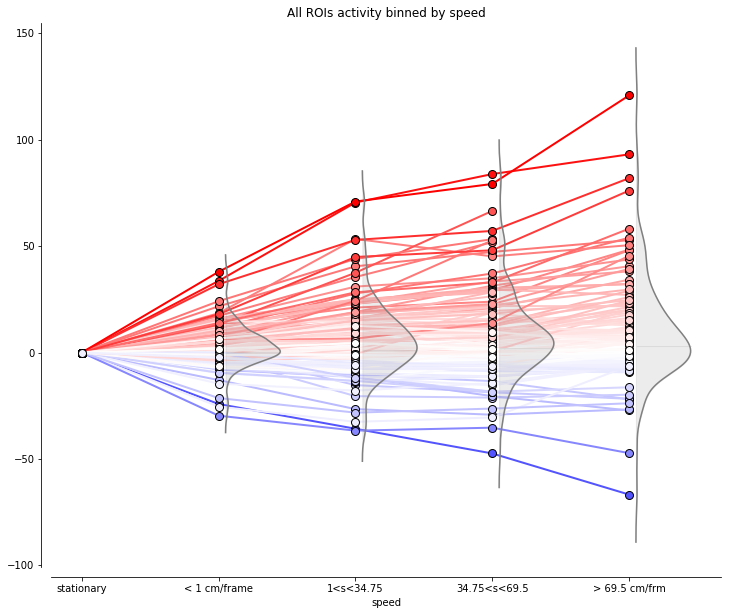

In [131]:
# f, axarr = plt.subplots(ncols =  3, nrows=4, figsize=(25, 18))
f, ax = plt.subplots(figsize=(12, 10))
normalize = True
th = 5

px_to_cm = 13.9

endpoints = [[], [], [], [], []]
for n, mouse in tqdm(enumerate(mice)):
    for s, sess in enumerate(sessions[mouse]):

        # axarr[n, s].set(title=f"{mouse} - {sess}")


        tracking, ang_vel, speed, shelter_distance, signals, _nrois, is_rec = get_mouse_session_data(mouse, sess)
        # remove speed outliers
        speed[speed>np.nanpercentile(speed, 99)] = np.nanpercentile(speed, 99)



        for nroi in np.arange(_nrois):
            trace = pd.DataFrame(dict(
                    x = np.int64(tracking['x'].values),
                    y = np.int64(tracking['y'].values),
                    s =speed,
                    sig = signals[nroi],
                    isrec = is_rec,
                )).interpolate()

            trace = trace.loc[trace.isrec > 0]

            stationary = trace.loc[trace.s < .1]
            slow = trace.loc[(trace.s > .1)&(trace.s < 1)]
            fast = trace.loc[trace.s > th] # trace.s.max()-1

            medium1 = trace.loc[(trace.s > 1)&(trace.s < th/2)]
            medium2 = trace.loc[(trace.s > th/2)&(trace.s < th)]


            y = np.array([stationary.sig.mean(), slow.sig.mean(), medium1.sig.mean(), medium2.sig.mean(), fast.sig.mean()])

            if normalize:
                y -= y[0]

            if not np.any(np.isnan(y[-1])):
                color = colorMap(y[-1], 'bwr', vmin=-100, vmax=100)
            else:
                color = colorMap(y[-2], 'bwr', vmin=-100, vmax=100)
            ax.plot([-1, 0, 1, 2, 3], y, 'o-', lw=2, ms=8, mec='k', label=f'roi {nroi}', color=color)
            # axarr[n, s]

            for k, yy in enumerate(y):
                if  not np.any(np.isnan(yy)):
                    endpoints[k].append(yy)


        # axarr[n, s].legend()
        # break
    # break
for k, endp in enumerate(endpoints):
    if k == 0: continue
    plot_kde(data=endp, vertical=True, normto=.4, z=k+.05-1, ax=ax,  color='gray', zorder=99)

cm_th = th*px_to_cm
ax.set(title='All ROIs activity binned by speed', xticks=[-1, 0, 1 ,2, 3], xticklabels=['stationary', '< 1 cm/frame', f'1<s<{round(cm_th/2, 2)}',
                f'{round(cm_th/2, 2)}<s<{cm_th}', f'> {cm_th} cm/frm'], xlabel='speed')

clean_axes(f)
save_figure(f, f'C:\\Users\\Federico\\Documents\\GitHub\\vgatPAG\\plots\\allrois_speed_modulation', verbose=False)
plt.show()


Do the same but splitting the data based on X position

4it [00:19,  4.75s/it]
4it [00:18,  4.63s/it]


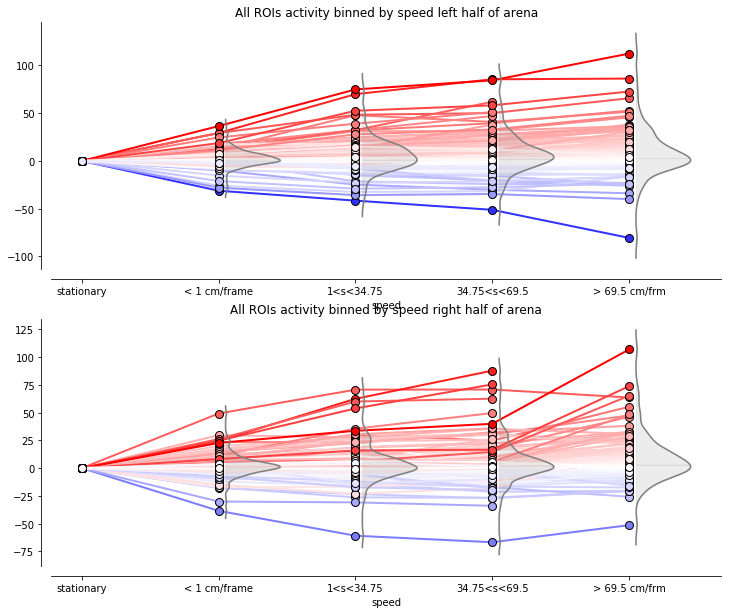

In [134]:
# f, axarr = plt.subplots(ncols =  3, nrows=4, figsize=(25, 18))
f, axarr = plt.subplots(nrows=2, figsize=(12, 10))
normalize = True

th = 5
xth = 550


px_to_cm = 13.9

for i in [0, 1]:
    ax = axarr[i]

    
    endpoints = [[], [], [], [], []]
    for n, mouse in tqdm(enumerate(mice)):
        for s, sess in enumerate(sessions[mouse]):

            # axarr[n, s].set(title=f"{mouse} - {sess}")


            tracking, ang_vel, speed, shelter_distance, signals, _nrois, is_rec = get_mouse_session_data(mouse, sess)
            # remove speed outliers
            speed[speed>np.nanpercentile(speed, 99)] = np.nanpercentile(speed, 99)



            for nroi in np.arange(_nrois):
                trace = pd.DataFrame(dict(
                        x = np.int64(tracking['x'].values),
                        y = np.int64(tracking['y'].values),
                        s =speed,
                        sig = signals[nroi],
                        isrec = is_rec,
                    )).interpolate()

                trace = trace.loc[trace.isrec > 0]

                if i == 0:
                    trace = trace.loc[trace.x < xth]
                else:
                    trace = trace.loc[trace.x > xth]

                stationary = trace.loc[trace.s < .1]
                slow = trace.loc[(trace.s > .1)&(trace.s < 1)]
                fast = trace.loc[trace.s > th] # trace.s.max()-1

                medium1 = trace.loc[(trace.s > 1)&(trace.s < th/2)]
                medium2 = trace.loc[(trace.s > th/2)&(trace.s < th)]


                y = np.array([stationary.sig.mean(), slow.sig.mean(), medium1.sig.mean(), medium2.sig.mean(), fast.sig.mean()])

                if normalize:
                    y -= y[0]

                if not np.any(np.isnan(y[-1])):
                    color = colorMap(y[-1], 'bwr', vmin=-100, vmax=100)
                else:
                    color = colorMap(y[-2], 'bwr', vmin=-100, vmax=100)
                ax.plot([-1, 0, 1, 2, 3], y, 'o-', lw=2, ms=8, mec='k', label=f'roi {nroi}', color=color)
                # axarr[n, s]

                for k, yy in enumerate(y):
                    if  not np.any(np.isnan(yy)):
                        endpoints[k].append(yy)


            # axarr[n, s].legend()
            # break
        # break
    for k, endp in enumerate(endpoints):
        if k == 0: continue
        plot_kde(data=endp, vertical=True, normto=.4, z=k+.05-1, ax=ax,  color='gray', zorder=99)

    cm_th = th*px_to_cm
    ax.set(title=f"All ROIs activity binned by speed {'left' if i == 0 else 'right'} half of arena", 
                        xticks=[-1, 0, 1 ,2, 3], xticklabels=['stationary', '< 1 cm/frame', f'1<s<{round(cm_th/2, 2)}',
                    f'{round(cm_th/2, 2)}<s<{cm_th}', f'> {cm_th} cm/frm'], xlabel='speed')

clean_axes(f)
save_figure(f, f'C:\\Users\\Federico\\Documents\\GitHub\\vgatPAG\\plots\\allrois_speed_xpos_modulation', verbose=False)
plt.show()


## Plotting tuning to angular velocity

4it [00:17,  4.45s/it]


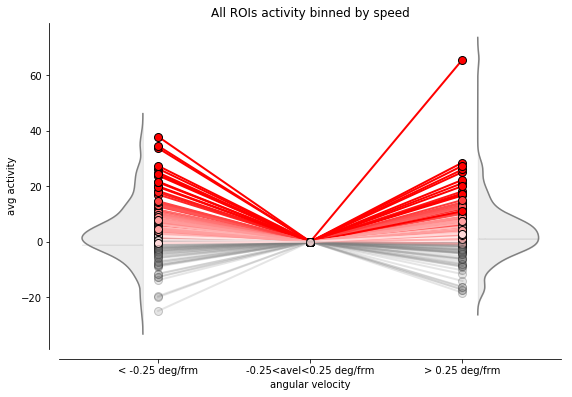

In [180]:
# f, axarr = plt.subplots(ncols =  3, nrows=4, figsize=(25, 18))
f, ax = plt.subplots(figsize=(9, 6))
normalize = True

th = 0.25

endpoints = [[], [], []]
for n, mouse in tqdm(enumerate(mice)):
    for s, sess in enumerate(sessions[mouse]):

        tracking, ang_vel, speed, shelter_distance, signals, _nrois, is_rec = get_mouse_session_data(mouse, sess)
    
        # Remove outliers
        ang_vel[ang_vel>np.nanpercentile(ang_vel, 99)] = np.nanpercentile(ang_vel, 99)
        ang_vel[ang_vel<np.nanpercentile(ang_vel, 1)] = np.nanpercentile(ang_vel, 1)



        for nroi in np.arange(_nrois):
            trace = pd.DataFrame(dict(
                    x = np.int64(tracking['x'].values),
                    y = np.int64(tracking['y'].values),
                    s =speed,
                    avel = ang_vel,
                    sig = signals[nroi],
                    isrec = is_rec,
                )).interpolate()

            trace = trace.loc[trace.isrec > 0]

            stationary = trace.loc[(trace.avel > -th)&(trace.avel<th)]
            cw = trace.loc[trace.avel > th]
            ccw = trace.loc[trace.avel < -th]
            


            y = np.array([ccw.sig.mean(), stationary.sig.mean(), cw.sig.mean()])

            if normalize:
                y -= y[1]

            if np.abs(np.nanmin(y)) > np.nanmax(y):
                # color = colorMap(np.nanmin(y), 'bwr', vmin=-20, vmax=20)
                color = 'gray'
                alpha = .2
            else:
                alpha = 1
                color = colorMap(np.nanmax(y), 'bwr', vmin=-20, vmax=20)

            # if not np.any(np.isnan(y[-1])):
            #     color = colorMap(y[-1], 'bwr', vmin=-100, vmax=100)
            # else:
            #     color = colorMap(y[-2], 'bwr', vmin=-100, vmax=100)
            ax.plot([-1, 0, 1], y, 'o-', lw=2, ms=8, mec='k', label=f'roi {nroi}', color=color, alpha=alpha)
            # axarr[n, s]

            for k, yy in enumerate(y):
                if not np.any(np.isnan(yy)):
                    endpoints[k].append(yy)



for k, endp in enumerate(endpoints):
    if k == 1: continue
    if k == 0:
        normto, z = -.4, -1.1
    elif k == 2:
        normto, z = .4, 1.1
    plot_kde(data=endp, vertical=True, normto=normto, z=z, ax=ax,  color='gray', zorder=99)

ax.set(title='All ROIs activity binned by speed', xticks=[-1, 0, 1], xticklabels=[f'< -{th} deg/frm', f'{-th}<avel<{th} deg/frm', f'> {th} deg/frm'],                          xlabel='angular velocity', ylabel='avg activity')

clean_axes(f)
save_figure(f, f'C:\\Users\\Federico\\Documents\\GitHub\\vgatPAG\\plots\\allrois_avel_modulation2', verbose=False)
plt.show()


plot angular velocity over tracking

4it [00:14,  3.74s/it]


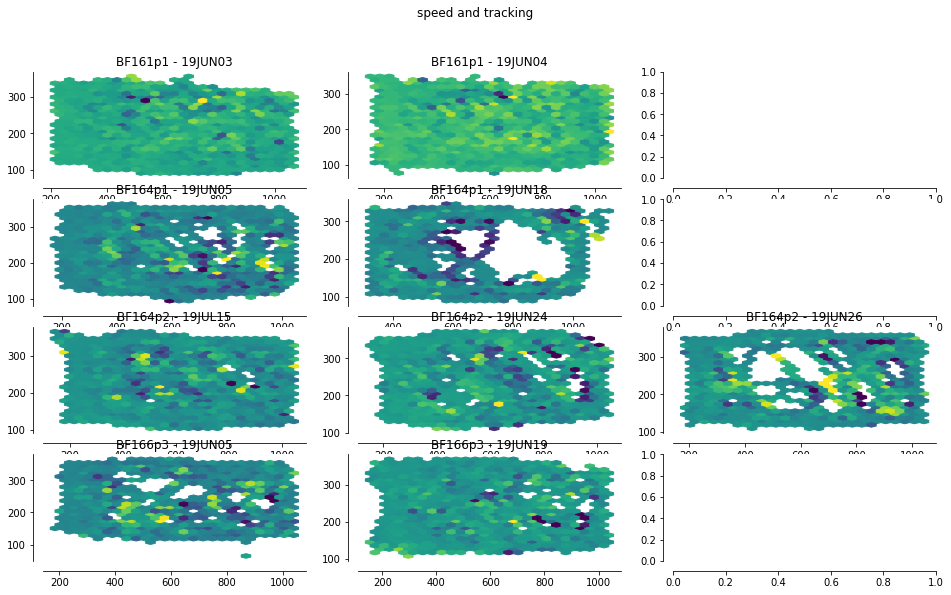

In [155]:

# Params
xbins, ybins = 25, 15
exploration_only = False

f, axarr = plt.subplots(ncols = 3, nrows=4, figsize=(16, 9))
f.suptitle(f"speed and tracking")

# Figure making
for m, mouse in tqdm(enumerate(mice)):
        for s, sess in enumerate(sessions[mouse]):
            tracking, ang_vel, speed, shelter_distance, signals, _nrois, is_rec = get_mouse_session_data(mouse, sess)
            # Remove outliers
            ang_vel[ang_vel>np.nanpercentile(ang_vel, 99)] = np.nanpercentile(ang_vel, 99)
            ang_vel[ang_vel<np.nanpercentile(ang_vel, 1)] = np.nanpercentile(ang_vel, 1)

            trace = pd.DataFrame(dict(
                x = np.int64(tracking['x'].values),
                y = np.int64(tracking['y'].values),
                ang_vel = ang_vel,
            ))

        
            # Plot tracking and binned activity
            axarr[m, s].hexbin(trace['x'], trace['y'], C=trace.ang_vel, gridsize=xbins, reduce_C_function=np.mean)
            axarr[m, s].set(title=f'{mouse} - {sess}')

# Clean axes and save figure
clean_axes(f)
# f.tight_layout()
plt.show()

# Fitting modelz
Fitting models to predict calcium activity

In [198]:
import statsmodels.api as sm

trace = pd.DataFrame(dict(
                    x = np.int64(tracking['x'].values),
                    y = np.int64(tracking['y'].values),
                    s =speed,
                    avel = ang_vel,
                    sig = signals[nroi],
                    isrec = is_rec,
                ))
trace = trace.loc[trace.isrec > 0]

exog = trace[['x', 'y', 's', 'avel']]
exog = sm.add_constant(exog, prepend=False)
endog = trace[['sig']]
model = sm.RLM(endog.reset_index(drop=True), exog.reset_index(drop=True)).fit() 


MissingDataError: exog contains inf or nans

In [191]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                    sig   No. Observations:               109773
Model:                            RLM   Df Residuals:                   109768
Method:                          IRLS   Df Model:                            4
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Wed, 13 May 2020                                         
Time:                        10:37:11                                         
No. Iterations:                    21                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x             -0.0097      0.000    -43.686      0.000      -0.010      -0.009
y             -0.0012      0.001     -2.081      0.037      -0.002   -7.02e-05
s              0.0235      0.012      1.882      0.060      -0.001       0.048
avel          -0.7193      0.103     -7.015      0.000      -0.920      -0.518
const         15.5678      0.154    101.143      0.000      15.266      15.869
==============================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

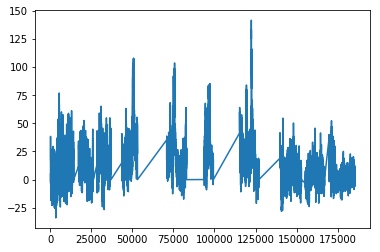

In [199]:
plt.plot(endog)

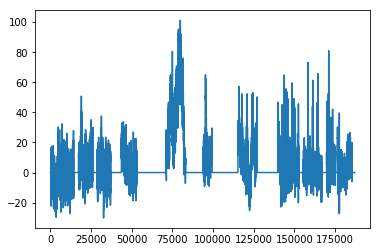

In [201]:
plt.plot(signals[0])

In [197]:
exog.isna().sum()

x            0
y            0
s        17818
avel         0
const        0
dtype: int64